In [1]:
import torch
import time
import numpy as np
import os
from datetime import datetime
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from pyDOE import lhs
import sys
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy import stats as sts
import math
from functorch import make_functional, vmap, grad, jacrev, hessian
import torch.autograd as autograd
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
def u_x(x):
    """
    三维区域上的函数 u(x, y, z)。
    拓展自二维版本 u(x, y) = (x^2 + y^2)^(1/3)。
    """
    r_squared = torch.sum(torch.pow(x, 2), 1)
    ux = torch.pow(r_squared, 1/3)
    return ux.unsqueeze(1)

In [3]:
class DNN(nn.Module):

    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    ### depth: depth of the network
    def __init__(self, in_dim, h_dim, out_dim, depth):
        super(DNN, self).__init__()
        self.depth = depth - 1
        self.list = nn.ModuleList()
        self.ln1 = nn.Linear(in_dim, h_dim)
        #self.act1 = nn.Sigmoid()
        self.act1 = nn.Tanh()
        # self.act1 = nn.ReLU()

        for i in range(self.depth):
            self.list.append(nn.Linear(h_dim, h_dim))

        self.lnd = nn.Linear(h_dim, out_dim, bias=False)

    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        for i in range(self.depth):
            out = self.list[i](out)
            out = self.act1(out)
        out = self.lnd(out)
        return out

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


In [5]:
model = DNN(3,20,1,3).to(device)

In [6]:
func_params = torch.load('best_model_nurwas.mdl', map_location=device)
# func_params = torch.load('best_model.mdl', map_location=device)
model.load_state_dict(func_params) 

<All keys matched successfully>

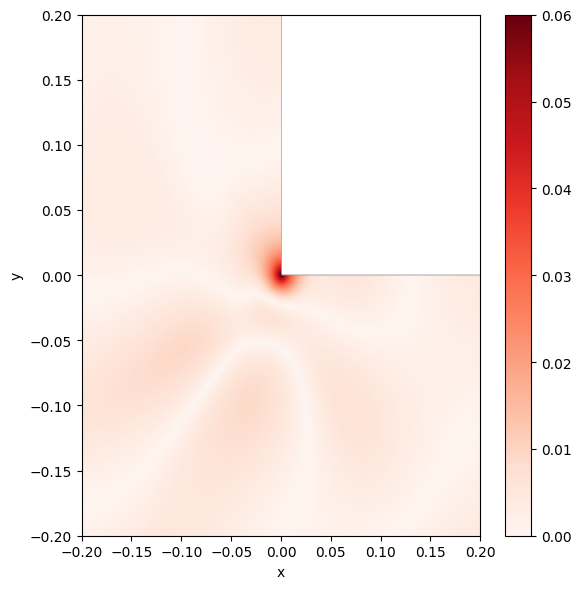


z=0平面相对L2误差：0.014694


In [7]:
# ============================== 生成z=0均匀点并可视化 ==============================
def generate_z0_uniform_grid(x_range=(-0.2, 0.2), y_range=(-0.2, 0.2), num_points=200):
    """生成z=0平面的均匀网格点（筛选有效区域）"""
    # 生成x/y均匀采样点
    x = torch.linspace(x_range[0], x_range[1], num_points)
    y = torch.linspace(y_range[0], y_range[1], num_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    Z = torch.zeros_like(X)  # z固定为0
    
    # 展平为(N,3)坐标并筛选有效区域（排除[0,0.2]×[0,0.2]）
    grid_points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=1)
    valid_mask = ~((grid_points[:, 0] >= 0) & (grid_points[:, 0] <= 0.2) & 
                   (grid_points[:, 1] >= 0) & (grid_points[:, 1] <= 0.2))
    valid_points = grid_points[valid_mask].to(device)
    
    return valid_points, X, Y, valid_mask

def plot_z0_results(valid_points, pred_u, truth_u, X, Y, valid_mask, num_points=200):
    """绘制z=0平面的真实值/预测值/误差分布图"""
    # 重构全尺寸数组（无效区域填充NaN）
    pred_full = np.full((num_points, num_points), np.nan)
    truth_full = np.full((num_points, num_points), np.nan)
    error_full = np.full((num_points, num_points), np.nan)
    
    # 计算有效点的网格索引
    x_flat = valid_points[:, 0].cpu().detach().numpy()
    y_flat = valid_points[:, 1].cpu().detach().numpy()
    x_idx = np.round((x_flat - (-0.2)) / (0.4 / (num_points - 1))).astype(int)
    y_idx = np.round((y_flat - (-0.2)) / (0.4 / (num_points - 1))).astype(int)
    
    # 填充有效区域数据
    pred_full[x_idx, y_idx] = pred_u.cpu().detach().numpy()
    truth_full[x_idx, y_idx] = truth_u.cpu().detach().numpy()
    error_full[x_idx, y_idx] = np.abs(pred_full[x_idx, y_idx] - truth_full[x_idx, y_idx])
    
    # 创建子图
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    '''
    # 1. 真实值热力图
    im1 = axes[0].imshow(truth_full.T, extent=[-0.2, 0.2, -0.2, 0.2], 
                         origin='lower', cmap='viridis', aspect='auto')
    axes[0].set_title('Truth Value (z=0)', fontsize=12)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0])
    
    # 2. 预测值热力图
    im2 = axes[1].imshow(pred_full.T, extent=[-0.2, 0.2, -0.2, 0.2], 
                         origin='lower', cmap='viridis', aspect='auto')
    axes[1].set_title('Predicted Value (z=0)', fontsize=12)
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    plt.colorbar(im2, ax=axes[1])
    '''
    # 3. 绝对误差热力图
    im3 = axes.imshow(error_full.T, extent=[-0.2, 0.2, -0.2, 0.2], 
                         origin='lower', cmap='Reds', aspect='auto', vmin=0)
    axes.set_xlabel('x')
    axes.set_ylabel('y')
    plt.colorbar(im3, ax=axes)
    
    plt.tight_layout()
    plt.show()

# ============================== 执行可视化 ==============================
# 生成z=0均匀点
z0_points, X_grid, Y_grid, valid_mask = generate_z0_uniform_grid(num_points=200)

# 计算真实值和预测值
truth_u = u_x(z0_points).squeeze()
pred_u = model(z0_points).squeeze()

# 绘制结果图
plot_z0_results(z0_points, pred_u, truth_u, X_grid, Y_grid, valid_mask, num_points=200)

# 计算z=0平面的相对L2误差
z0_l2 = torch.sqrt(torch.mean(torch.pow(pred_u - truth_u, 2))) / torch.sqrt(
    torch.mean(torch.pow(truth_u, 2))
)
print(f"\nz=0平面相对L2误差：{z0_l2.item():.6f}")


In [8]:
func_params = torch.load('best_model.mdl', map_location=device)
model.load_state_dict(func_params) 

<All keys matched successfully>

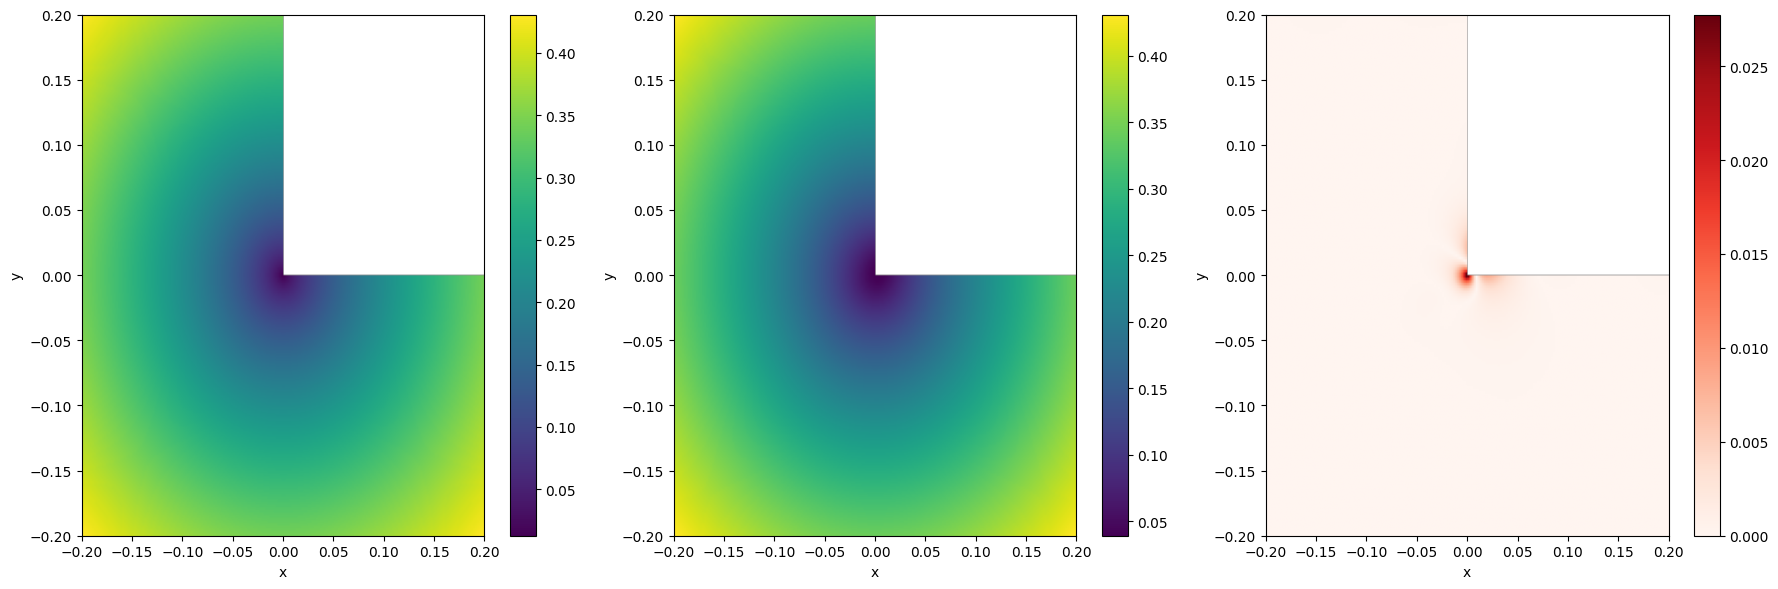


z=0平面相对L2误差：0.002316


In [9]:
# ============================== 生成z=0均匀点并可视化 ==============================
def generate_z0_uniform_grid(x_range=(-0.2, 0.2), y_range=(-0.2, 0.2), num_points=200):
    """生成z=0平面的均匀网格点（筛选有效区域）"""
    # 生成x/y均匀采样点
    x = torch.linspace(x_range[0], x_range[1], num_points)
    y = torch.linspace(y_range[0], y_range[1], num_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    Z = torch.zeros_like(X)  # z固定为0
    
    # 展平为(N,3)坐标并筛选有效区域（排除[0,0.2]×[0,0.2]）
    grid_points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=1)
    valid_mask = ~((grid_points[:, 0] >= 0) & (grid_points[:, 0] <= 0.2) & 
                   (grid_points[:, 1] >= 0) & (grid_points[:, 1] <= 0.2))
    valid_points = grid_points[valid_mask].to(device)
    
    return valid_points, X, Y, valid_mask

def plot_z0_results(valid_points, pred_u, truth_u, X, Y, valid_mask, num_points=200):
    """绘制z=0平面的真实值/预测值/误差分布图"""
    # 重构全尺寸数组（无效区域填充NaN）
    pred_full = np.full((num_points, num_points), np.nan)
    truth_full = np.full((num_points, num_points), np.nan)
    error_full = np.full((num_points, num_points), np.nan)
    
    # 计算有效点的网格索引
    x_flat = valid_points[:, 0].cpu().detach().numpy()
    y_flat = valid_points[:, 1].cpu().detach().numpy()
    x_idx = np.round((x_flat - (-0.2)) / (0.4 / (num_points - 1))).astype(int)
    y_idx = np.round((y_flat - (-0.2)) / (0.4 / (num_points - 1))).astype(int)
    
    # 填充有效区域数据
    pred_full[x_idx, y_idx] = pred_u.cpu().detach().numpy()
    truth_full[x_idx, y_idx] = truth_u.cpu().detach().numpy()
    error_full[x_idx, y_idx] = np.abs(pred_full[x_idx, y_idx] - truth_full[x_idx, y_idx])
    
    # 创建子图
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. 真实值热力图
    im1 = axes[0].imshow(truth_full.T, extent=[-0.2, 0.2, -0.2, 0.2], 
                         origin='lower', cmap='viridis', aspect='auto')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0])
    
    # 2. 预测值热力图
    im2 = axes[1].imshow(pred_full.T, extent=[-0.2, 0.2, -0.2, 0.2], 
                         origin='lower', cmap='viridis', aspect='auto')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    plt.colorbar(im2, ax=axes[1])
    
    # 3. 绝对误差热力图
    im3 = axes[2].imshow(error_full.T, extent=[-0.2, 0.2, -0.2, 0.2], 
                         origin='lower', cmap='Reds', aspect='auto', vmin=0)
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

# ============================== 执行可视化 ==============================
# 生成z=0均匀点
z0_points, X_grid, Y_grid, valid_mask = generate_z0_uniform_grid(num_points=200)

# 计算真实值和预测值
truth_u = u_x(z0_points).squeeze()
pred_u = model(z0_points).squeeze()

# 绘制结果图
plot_z0_results(z0_points, pred_u, truth_u, X_grid, Y_grid, valid_mask, num_points=200)

# 计算z=0平面的相对L2误差
z0_l2 = torch.sqrt(torch.mean(torch.pow(pred_u - truth_u, 2))) / torch.sqrt(
    torch.mean(torch.pow(truth_u, 2))
)
print(f"\nz=0平面相对L2误差：{z0_l2.item():.6f}")
